In [1]:
from osgeo import gdal
import sklearn as sk
import input_test
import numpy as np
import tensorflow as tf
import time 

In [4]:
batch_size = 100
dropout = 0.85
n_classes = 4
epsilon=1e-08
epochs=21
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
decay=0.9
bands=7
epsilon=1e-08
learning_rate = 0.000001

In [5]:
dataset= input_test.read_data_sets('/media/gitecx/Nuevo vol/ASIAlac/Dataset/Size_20_Overlap_50_70%_Oversampling',
                                   '',bands,n_clases=n_classes)  

UnboundLocalError: local variable 'dirs' referenced before assignment

In [6]:
dataset= input_test.read_data_sets('','/media/arnol/Gits/Datasset/Conjunto de validadion 20x20',bands,n_clases=n_classes)  

KeyboardInterrupt: 

In [4]:
def continue_training (model_path):
    from sklearn.metrics import confusion_matrix
    with tf.Session() as sess :
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        
#####################################################
#### Continue Training
#####################################################
        
        for i in range (1,int(33688/batch_size)*int(epochs)):
            
            batch_xs, batch_ys = dataset.train.next_batch(batch_size)
            # Fit training using batch data
            start_time = time.clock()
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
            if( i%int(33688/batch_size)==0):
            
                epoch_time = time.clock()
                print "time this epoch=", (epoch_time-start_time)
                correct2 =0
                y_p = tf.argmax(pred,1)
                step = 1
                y_true_a = 0
                y_pred_a = 0
                limit = 8410/batch_size
            
######################################################
###   Continue_Testing 
######################################################
                while step <= limit:
                    t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                    predictions = sess.run([correct_pred], feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.})
                    prediction  = tf.argmax(pred,1)
                    y_true = np.argmax(t_batch_ys,1)
                    labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                    
                    if (step ==1):
                        y_true_a+=y_true
                        y_pred_a+=labels              
                    else:
                        y_true_a = np.concatenate((y_true_a, y_true))
                        y_pred_a = np.concatenate((y_pred_a, labels))
                    step+=1

                a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
                a3=a3.eval()
                accuaracy,matrix=precision_measure(a3)
                print ("test accuracy "+str(accuaracy))

        np.set_printoptions(precision=3, suppress=True)
        print (a3)
        print (matrix)
        model= "./modelos/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_bath_"+str(bath_size)+"_c_"+".ckpt"
        save_path = saver.save(sess, model)
        print ("model saved")
        print (model)
        sess.close()

In [5]:
def precision_measure (a2):

    b2=a2.astype(float)
    for i in range(n_classes):
        a1=b2[i]
        sum_a1=np.sum(b2[i])
        if(sum_a1 > 0):
            b2[i]=a1/sum_a1
    #print ('Matrix de confusion con medidas de desempeño')
    np.set_printoptions(precision=3)
    pro=(b2[0][0]+b2[1][1]+b2[2][2]+b2[3][3]+b2[4][4]+b2[5][5]+b2[6][6]+b2[7][7]+b2[8][8]+b2[9][9])/10    
    return pro,b2

In [6]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [7]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,20,20,bands])
y = tf.placeholder("float", [None, n_classes])
    
weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=decay,  epsilon=epsilon).minimize(cost)
#optimizer =tf.train.AdadeltaOptimizer(learning_rate=learning_rate,rho=decay, epsilon=1e-08).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()
saver = tf.train.Saver()


In [8]:
def test_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = 8410/batch_size
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1

        a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
        a3=a3.eval()
        accuaracy,matrix=precision_measure(a3)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (a3)
        print (matrix)
        sess.close()
    return matrix

In [ ]:
def validation_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/batch_size
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys = dataset.validation.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1

        a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
        a3=a3.eval()
        accuaracy,matrix=precision_measure(a3)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (a3)
        print (matrix)
        sess.close()
    return matrix

In [9]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(init)
    print ("Start Train")     
    
##########################################################            
###   TRAIN
##########################################################
    
    # Keep training until reach max iterations
    for i in range (1,int(33688/batch_size)*int(epochs)): 
        
        batch_xs, batch_ys = dataset.train.next_batch(batch_size)
        # Fit training using batch data
        start_time = time.clock()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if(i%int(33688/batch_size)==0):
            
            epoch_time = time.clock()
            print "time this epoch=", (epoch_time-start_time)
            correct2 =0
            y_p = tf.argmax(pred,1)
            step = 1
            y_true_a = 0
            y_pred_a = 0
            limit = 8410/batch_size
######################################################
###   Test 
######################################################
            while step <= limit:
        
                t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                prediction  = tf.argmax(pred,1)
                y_true = np.argmax(t_batch_ys,1)
                labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                
                if (step ==1):
                    y_true_a+=y_true
                    y_pred_a+=labels              
                else:
                    y_true_a = np.concatenate((y_true_a, y_true))
                    y_pred_a = np.concatenate((y_pred_a, labels))
                step+=1

            a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
            a3=a3.eval()
            accuaracy,matrix=precision_measure(a3)
            print ("test accuracy "+str(accuaracy))
            
#######################################################   
#   END TRAIN             
############################
#           %matplotlib
#           import matplotlib.pyplot as plt
#           l=np.arange(0.0, epochs-1, 1.)
#           plt.plot(val,l, 'r--') 
    print "Optimization Finished!"    
    model= "./modelos/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+".ckpt"
    np.set_printoptions(precision=3, suppress=True)
    print (a3)
    print (matrix)
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)
    sess.close()        
        

# ##########################################################            
# ###   VALIDATION
# ###############################################################                                                        
#         if (validation==True):
#             print ("Validation")
#             dataset= input_test.read_data_sets('','/media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_validation',bands)
#             step2 = 1
#             y_true_a = 0
#             y_pred_a = 0
#             saver.restore(sess,save_path)
#             print ("Model successfully restored")
# ######################################################            
# #tf.contrib.metrics.confusion_matrix(predictions, labels, num_classes=None, dtype=tf.int32, name=None)
# ####################################################
#             while step2 <= (int(23871/batch_size)):
        
#                 batch_xs, batch_ys = dataset.validation.next_batch(batch_size)
#                 predictions = sess.run([correct_pred], feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
#                 prediction  = tf.argmax(pred,1)
#                 y_true = np.argmax(batch_ys,1)
#                 labels = prediction.eval(feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.}, session=sess)    

#                 if (step2 ==1):
#                     y_true_a+=y_true
#                     y_pred_a+=labels              
#                 else:
#                     y_true_a = np.concatenate((y_true_a, y_true))
#                     y_pred_a = np.concatenate((y_pred_a, labels))
#                 step2+=1
                
            
#             a3=tf.contrib.metrics.confusion_matrix(y_pred_a, y_true_a, num_classes=None, dtype=tf.int32)
#             a3=a3.eval()
#             print np.sum(a3)
#             accuaracy,matrix=precision_measure(a3)
#             print ("validation accuracy" +str(accuaracy))
#             np.set_printoptions(precision=3)
#             print (matrix)                  



Start Train
time this epoch= 0.036138
test accuracy 0.148475283526
time this epoch= 0.034401
test accuracy 0.201084229148
time this epoch= 0.034994
test accuracy 0.331765326244
time this epoch= 0.035213
test accuracy 0.388279825606
time this epoch= 0.034364
test accuracy 0.432937710124
time this epoch= 0.034678
test accuracy 0.451070882345
time this epoch= 0.035528
test accuracy 0.47758028662
time this epoch= 0.036416
test accuracy 0.500275965939
time this epoch= 0.034946
test accuracy 0.521994391449
time this epoch= 0.033519
test accuracy 0.535034360964
time this epoch= 0.035544
test accuracy 0.54803205325
time this epoch= 0.032481
test accuracy 0.557928674376
time this epoch= 0.03485
test accuracy 0.569945756374
time this epoch= 0.034568
test accuracy 0.581233048391
time this epoch= 0.034402
test accuracy 0.587474543546
time this epoch= 0.033905
test accuracy 0.591433577932
time this epoch= 0.034042
test accuracy 0.60322151154
time this epoch= 0.03317
test accuracy 0.605758768326
tim

# Restaurar modelos

## Redefinir variables

In [8]:
continue_training('./modelos/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.9_epsilon_1e-08.ckpt')

Model successfully restored
time this epoch= 0.03437
test accuracy 0.6216772949
time this epoch= 0.033878
test accuracy 0.62436334703
time this epoch= 0.033289
test accuracy 0.627434761969
time this epoch= 0.035057
test accuracy 0.633782687992
time this epoch= 0.03507
test accuracy 0.638913453506
time this epoch= 0.035077
test accuracy 0.64216191435
time this epoch= 0.03448
test accuracy 0.64561019387
time this epoch= 0.034756
test accuracy 0.650939054601
time this epoch= 0.034118
test accuracy 0.6535763058
time this epoch= 0.034412
test accuracy 0.655212966581
time this epoch= 0.036144
test accuracy 0.661107502549
time this epoch= 0.034327
test accuracy 0.662098085973
time this epoch= 0.036879
test accuracy 0.663043211871
time this epoch= 0.036026
test accuracy 0.665611195913
time this epoch= 0.03321
test accuracy 0.665353825416
time this epoch= 0.035182
test accuracy 0.668062440734
time this epoch= 0.03562
test accuracy 0.669908811878
time this epoch= 0.036825
test accuracy 0.6711858

In [9]:
continue_training('./modelos/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.9_epsilon_1e-08_c_.ckpt')

Model successfully restored
time this epoch= 0.038032
test accuracy 0.678447623794
time this epoch= 0.036039
test accuracy 0.679645333103
time this epoch= 0.0356380000001
test accuracy 0.681269450457
time this epoch= 0.034114
test accuracy 0.68283279032
time this epoch= 0.0357739999999
test accuracy 0.68498375486
time this epoch= 0.034677
test accuracy 0.687049828102
time this epoch= 0.035528
test accuracy 0.685774716755
time this epoch= 0.036191
test accuracy 0.687320234287
time this epoch= 0.036156
test accuracy 0.687237089202
time this epoch= 0.036246
test accuracy 0.687703895986
time this epoch= 0.034088
test accuracy 0.690645608119
time this epoch= 0.035655
test accuracy 0.689277172989
time this epoch= 0.035489
test accuracy 0.690736617143
time this epoch= 0.0339220000001
test accuracy 0.689880884071
time this epoch= 0.035257
test accuracy 0.691975525401
time this epoch= 0.036071
test accuracy 0.692605726149
time this epoch= 0.0348750000001
test accuracy 0.6932799111
time this epo

In [8]:
continue_training('./modelos/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.9_epsilon_1e-08_c_.ckpt')

Model successfully restored
time this epoch= 0.035771
test accuracy 0.697444893265
time this epoch= 0.035539
test accuracy 0.699346041922
time this epoch= 0.03599
test accuracy 0.700306807345
time this epoch= 0.036219
test accuracy 0.701449016911
time this epoch= 0.035799
test accuracy 0.701261514384
time this epoch= 0.035192
test accuracy 0.701774988933
time this epoch= 0.034902
test accuracy 0.702952507571
time this epoch= 0.035394
test accuracy 0.703304343814
time this epoch= 0.03668
test accuracy 0.702559434059
time this epoch= 0.030811
test accuracy 0.70248743365
time this epoch= 0.036199
test accuracy 0.702626903634
time this epoch= 0.036536
test accuracy 0.702276825559
time this epoch= 0.034809
test accuracy 0.703279552486
time this epoch= 0.036247
test accuracy 0.702134705358
time this epoch= 0.03605
test accuracy 0.703090695754
time this epoch= 0.034969
test accuracy 0.704690340246
time this epoch= 0.035818
test accuracy 0.703659745692
time this epoch= 0.034672
test accuracy 0

# Este es

In [9]:
continue_training('./modelos/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.85_decay_0.9_epsilon_1e-08_c_.ckpt')

Model successfully restored
time this epoch= 0.035439
test accuracy 0.712898669725
time this epoch= 0.035942
test accuracy 0.712966960311
time this epoch= 0.035555
test accuracy 0.712840456948
time this epoch= 0.034052
test accuracy 0.712763734319
time this epoch= 0.035209
test accuracy 0.71253056087
time this epoch= 0.035549
test accuracy 0.712584762785
time this epoch= 0.036538
test accuracy 0.713160537222
time this epoch= 0.037738
test accuracy 0.712962007712
time this epoch= 0.034847
test accuracy 0.712503027396
time this epoch= 0.036391
test accuracy 0.713243088513
time this epoch= 0.035993
test accuracy 0.713556744891
time this epoch= 0.035985
test accuracy 0.71296545786
time this epoch= 0.03435
test accuracy 0.713157266203
time this epoch= 0.035744
test accuracy 0.713193801113
time this epoch= 0.034315
test accuracy 0.713546233672
time this epoch= 0.036393
test accuracy 0.71384065835
time this epoch= 0.036421
test accuracy 0.71373742509
time this epoch= 0.03603
test accuracy 0.7

# Test Model

In [9]:
matrix=test_model('./modelos/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.85_decay_0.9_epsilon_1e-08_c_.ckpt')

Model successfully restored
test accuracy 0.712551612568
[[800   6  11   3 170  14  91  71   0  12]
 [  0 571   1  81   0   3  30   7  13   4]
 [ 12 126 817 322   2   0   3  11   0   0]
 [  1 124   9 418   0   3  20   6  83   1]
 [ 18   0   2   1 595 115  42 137  10   4]
 [  3   0   1   0  33 508  67  78   5  45]
 [  4   3   0   3  13  47 364 110  37  17]
 [  2   8   0   4  17 133 205 415   3   8]
 [  0   1   0   8   2   3   2   0 686   0]
 [  0   0   0   0   5  14  17   6   3 750]]
[[ 0.679  0.005  0.009  0.003  0.144  0.012  0.077  0.06   0.     0.01 ]
 [ 0.     0.804  0.001  0.114  0.     0.004  0.042  0.01   0.018  0.006]
 [ 0.009  0.097  0.632  0.249  0.002  0.     0.002  0.009  0.     0.   ]
 [ 0.002  0.186  0.014  0.629  0.     0.005  0.03   0.009  0.125  0.002]
 [ 0.019  0.     0.002  0.001  0.644  0.124  0.045  0.148  0.011  0.004]
 [ 0.004  0.     0.001  0.     0.045  0.686  0.091  0.105  0.007  0.061]
 [ 0.007  0.005  0.     0.005  0.022  0.079  0.609  0.184  0.062  0.028]
 

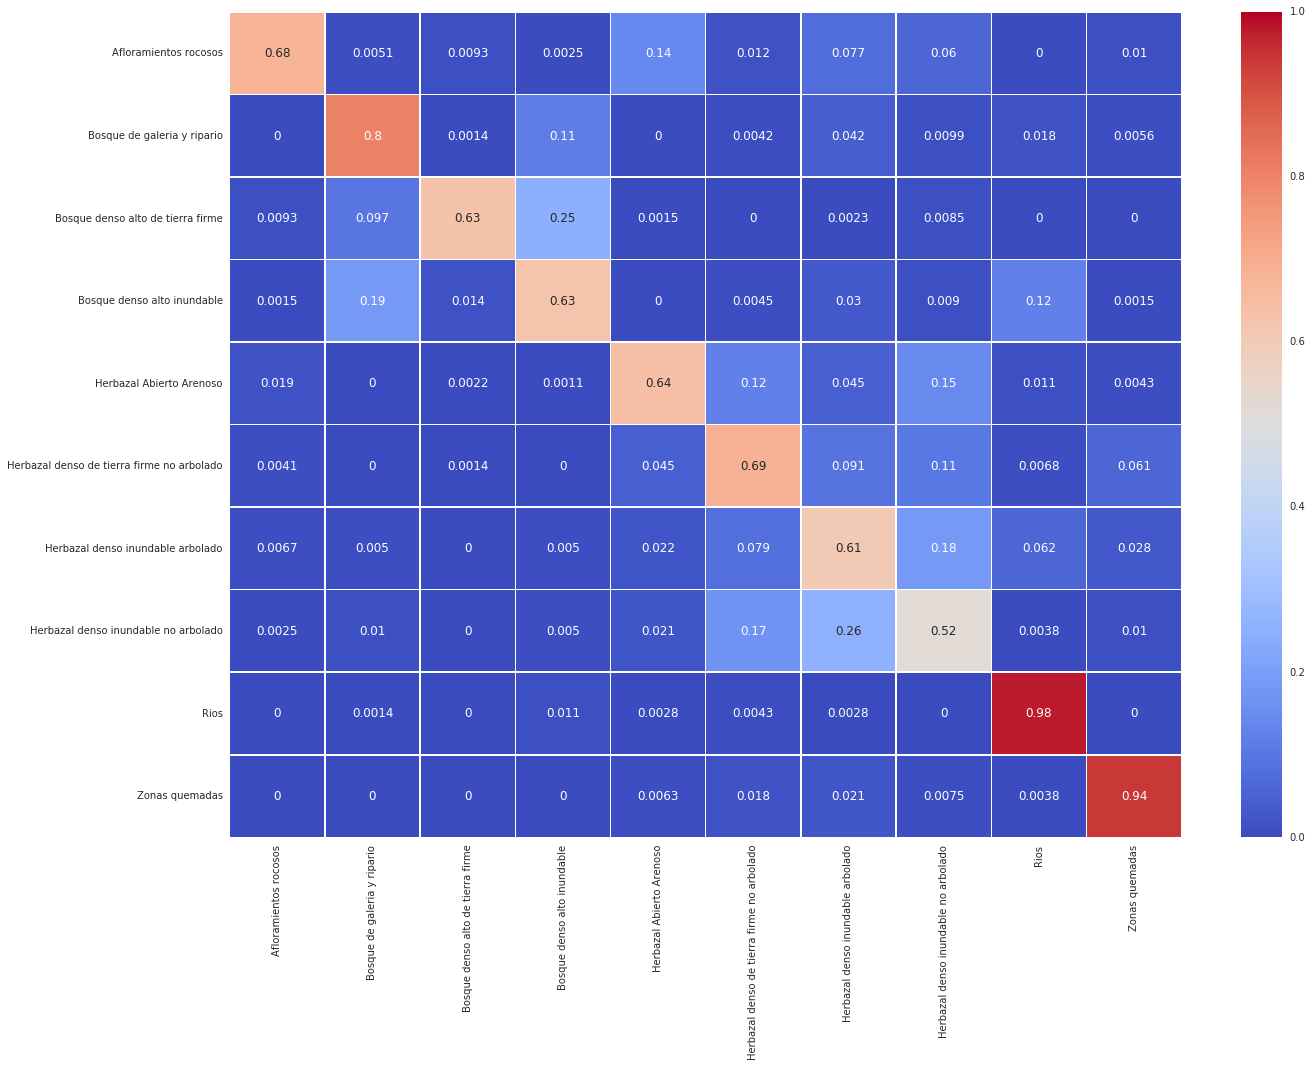

In [94]:
labels= ["Afloramientos rocosos","Bosque de galeria y ripario","Bosque denso alto de tierra firme","Bosque denso alto inundable",
                "Herbazal Abierto Arenoso","Herbazal denso de tierra firme no arbolado","Herbazal denso inundable arbolado",
                "Herbazal denso inundable no arbolado","Rios","Zonas quemadas"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,vmin=0., vmax=1.,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()